<a href="https://www.kaggle.com/code/umerellous/face-classification?scriptVersionId=254600207" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchsummary import summary
import json

In [26]:
# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Define paths
train_path = "/kaggle/input/face-classification-deep-learning-cs-405/dataset/train"
test_path = "/kaggle/input/face-classification-deep-learning-cs-405/dataset"

In [27]:
# Constants
EPOCHS = 10
BATCH_SIZE = 64
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                images.append((img_path, self.class_to_idx[class_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [29]:
# Training data generator
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Validation data generator
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [30]:
full_dataset = FaceDataset(root_dir=train_path, transform=train_transform)

In [32]:
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

In [33]:
# Apply different transform to validation and test sets
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

In [31]:
# Split into train (70%), validation (20%), and test (10%) sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

In [35]:
# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

In [61]:
class FaceClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FaceClassifier, self).__init__()
        # Use ResNet50 as backbone
        self.backbone = models.resnet50(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Custom classification head
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

In [62]:
print("Model Summary")
summary(model, input_size=(3, IMG_SIZE, IMG_SIZE))

Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14     

In [57]:
# Initialize model
num_classes = len(full_dataset.classes)
model = FaceClassifier(num_classes=num_classes).to(DEVICE)

In [ ]:
def train(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    best_acc = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(EPOCHS):
        model.train()
        running_loss, correct = 0.0, 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        # Validation
        model.eval()
        correct_val, val_loss_total = 0, 0.0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item() * imgs.size(0)
                correct_val += (outputs.argmax(1) == labels).sum().item()
        val_acc = correct_val / len(val_loader.dataset)
        val_loss = val_loss_total / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
            print("Best model saved")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            correct += (outputs.argmax(1) == labels).sum().item()
    print(f"Test Accuracy: {correct / len(loader.dataset):.4f}")


In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [51]:
if __name__ == "__main__":

    train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader)

    model.load_state_dict(torch.load("best_model.pt"))
    test(model, test_loader)
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Epoch 1: 100%|██████████| 1532/1532 [08:10<00:00,  2.68it/s]
Train Loss: 7.6906, Train Acc: 0.0571
Validation Loss: 6.2763, Accuracy: 0.2765
Best model saved
Epoch 2: 100%|██████████| 1532/1532 [08:12<00:00,  2.67it/s]
Train Loss: 5.1278, Train Acc: 0.4174
Validation Loss: 3.9580, Accuracy: 0.6339
Best model saved
Epoch 3: 100%|██████████| 1532/1532 [08:15<00:00,  2.65it/s]
Train Loss: 2.8623, Train Acc: 0.7750
Validation Loss: 2.3665, Accuracy: 0.7009
Best model saved
Epoch 4: 100%|██████████| 1532/1532 [08:15<00:00,  2.65it/s]
Train Loss: 1.3474, Train Acc: 0.9107
Validation Loss: 1.6241, Accuracy: 0.8035
Best model saved
Epoch 5: 100%|██████████| 1532/1532 [08:13<00:00,  2.66it/s]
Train Loss: 0.6273, Train Acc: 0.9541
Validation Loss: 1.3855, Accuracy: 0.8080
Best model saved
Epoch 6: 100%|██████████| 1532/1532 [08:13<00:00,  2.66it/s]
Train Loss: 0.3146, Train Acc: 0.9755
Validation Loss: 1.2874, Accuracy: 0.8128
Epoch 7: 100%|██████████| 1532/1532 [08:15<00:00,  2.65it/s]
Train Lo

####Plotting Graphs

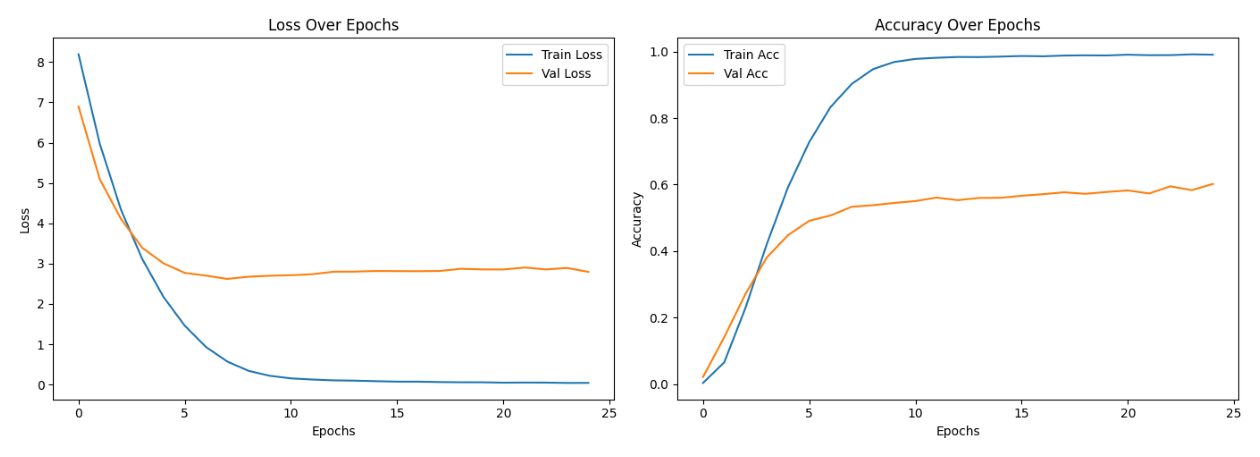

In [50]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
def predict_and_save(model, test_dir, output_csv_path, img_size=(224, 224), batch_size=32):
    # Create test data generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )

    # Make predictions
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Map class indices back to class labels
    class_indices = {v: k for k, v in test_generator.class_indices.items()}
    predicted_labels = [class_indices[i] for i in predicted_classes]

    # Get file names
    filenames = test_generator.filenames
    filenames = [f.split('/')[-1] for f in filenames]

    # Create DataFrame and save
    results_df = pd.DataFrame({
        'filename': filenames,
        'predicted_class': predicted_labels
    })

    results_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")


In [52]:
predict_and_save(model, test_dir=test_path, output_csv_path='predictions.csv')

Predicting: 100%|██████████| 35000/35000 [09:19<00:00, 62.52it/s]
Predictions saved to predictions.csv
